In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [148]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src import crs, PublicPredictor, PrevPublicPredictor
from IPython.display import clear_output, Markdown, display

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [4]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트1-104-303,아파트1-104-404,아파트1-104-408,아파트1-104-503,아파트1-104-507,아파트1-104-606,아파트1-104-705,아파트1-104-708,아파트1-104-902,아파트1-104-905
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,10,111,39,151,181,180,290,184,176,148
2,251,481,177,218,397,297,339,197,348,288,...,77,107,30,114,151,151,263,177,158,127
3,255,424,203,222,378,303,349,202,357,368,...,77,120,28,116,163,157,281,182,171,127
4,252,355,180,230,368,278,298,188,346,365,...,76,64,58,109,151,148,257,175,140,121
5,230,357,258,203,414,270,418,156,320,265,...,150,63,75,137,115,13,84,149,36,117


실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

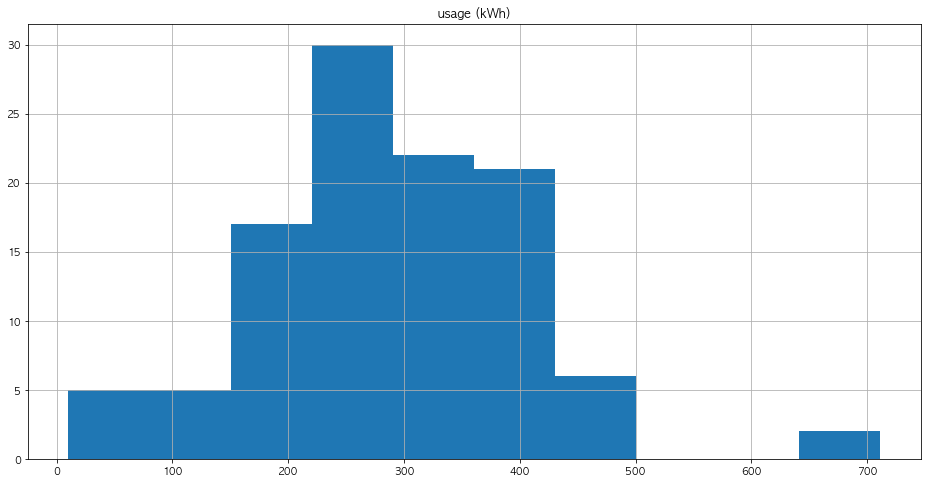

In [123]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)
month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

# 공용부 사용량이 APT 상에서 30%를 차지하도록 설정
public_kWh = APT - households_kWh

# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df,
    month=_month
)

month_df[['usage (kWh)']].hist(bins=10, figsize=(16,8))

pp.predict

In [128]:
display(Markpublic_kWh

13330

In [125]:
month_df.head()

,name,usage (kWh)
0,아파트1-101-1002,253
1,아파트1-101-104,689
2,아파트1-101-1102,183
3,아파트1-101-1202,239
4,아파트1-101-1302,455


## Random 전기절약 Target 정하기

In [127]:
target = month_df[(month_df['usage (kWh)'] > 150) & (month_df['usage (kWh)'] < 200)].sample(n=1)
target_usage = target['usage (kWh)'].values[0]

target

,name,usage (kWh)
2,아파트1-101-1102,183


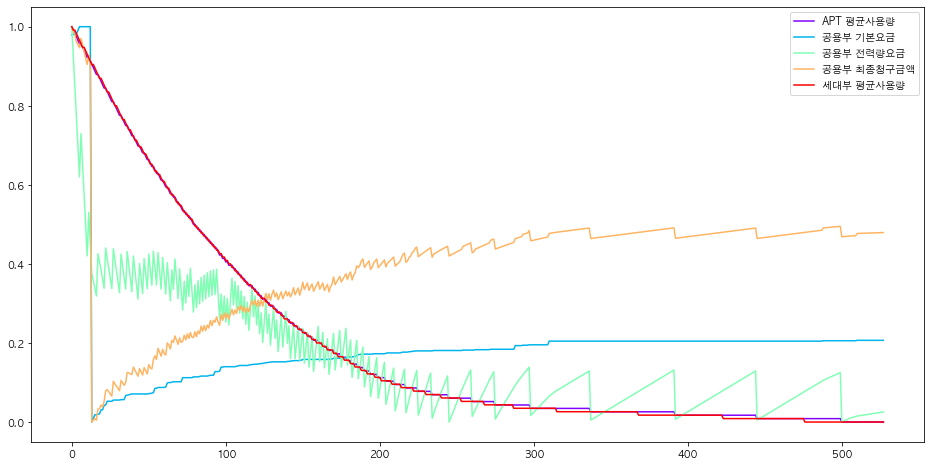

,APT 평균사용량,공용부 기본요금,공용부 전력량요금,공용부 최종청구금액,세대부 평균사용량
0,411,459190,1805867,2655270,287.0
1,410,459720,1796743,2648340,286.0
2,409,460250,1787549,2641330,286.0
3,408,460250,1778286,2630800,285.0
4,407,465050,1769024,2625730,284.0


In [129]:
saving_pd = pd.DataFrame(columns=['APT 평균사용량', '공용부 기본요금', '공용부 전력량요금', '공용부 최종청구금액'])

while True:
    if len(month_df[month_df['usage (kWh)'] > target_usage].index) == 0:
        break

    month_df['usage (kWh)'] = month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    households_kWh = month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh

    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=month_df,
        month=_month
    )

    public_bill = pp.predict['예측 요금']

    saving_pd = saving_pd.append({
        "APT 평균사용량": round(APT / len(month_df)),
        "세대부 평균사용량": round(households_kWh / len(month_df)),
        "공용부 기본요금": pp.basic,
        "공용부 전력량요금": pp.elec_rate,
        "공용부 최종청구금액": public_bill
    }, ignore_index=True)

plt.figure(figsize=(16,8))

my_palette = plt.cm.get_cmap("rainbow", len(norm_saving_pd.columns))
norm_saving_pd = saving_pd.copy()

for idx,col in enumerate(norm_saving_pd):
    norm_saving_pd[col] = (norm_saving_pd[col] - norm_saving_pd[col].min()) / (norm_saving_pd[col].max() - norm_saving_pd[col].min())
    plt.plot(norm_saving_pd[col], label=col, color=my_palette(idx))
    
plt.legend()
plt.show()

saving_pd.head()

## 공용부 기본요금 분석

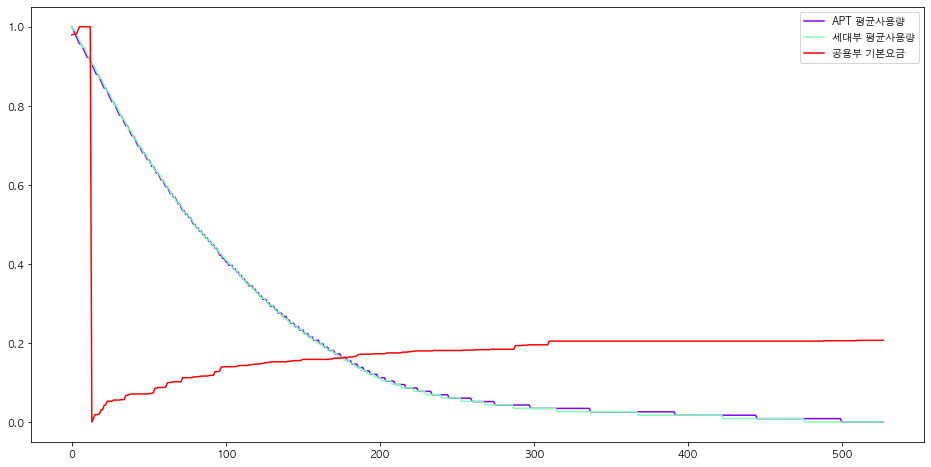

,APT 평균사용량,공용부 기본요금,공용부 전력량요금,공용부 최종청구금액,세대부 평균사용량
0,411,459190,1805867,2655270,287.0
1,410,459720,1796743,2648340,286.0
2,409,460250,1787549,2641330,286.0
3,408,460250,1778286,2630800,285.0
4,407,465050,1769024,2625730,284.0


In [152]:
matplotlib.use('module://matplotlib_inline.backend_inline')
plt.figure(figsize=(16,8))

norm_saving_pd = saving_pd[['APT 평균사용량', '세대부 평균사용량', '공용부 기본요금']].copy()
my_palette = plt.cm.get_cmap("rainbow", len(norm_saving_pd.columns))

for idx,col in enumerate(norm_saving_pd):
    norm_saving_pd[col] = (norm_saving_pd[col] - norm_saving_pd[col].min()) / (norm_saving_pd[col].max() - norm_saving_pd[col].min())
    plt.plot(norm_saving_pd[col], label=col, color=my_palette(idx))
    
plt.legend()
plt.show()

saving_pd.head()